# Preparar datos SVD

# 0. Instalación

Instalar la biblioteca SDV.

In [6]:
!pip install sdv

  Using cached sdv-1.5.0-py2.py3-none-any.whl (130 kB)
  Using cached Faker-14.2.1-py3-none-any.whl (1.6 MB)
  Using cached sdmetrics-0.11.1-py2.py3-none-any.whl (160 kB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  Using cached numpy-1.24.4-cp38-cp38-win32.whl (12.5 MB)
  Using cached rdt-1.7.0-py2.py3-none-any.whl (70 kB)
  Using cached copulas-0.9.2-py2.py3-none-any.whl (54 kB)
  Using cached ctgan-0.7.5-py2.py3-none-any.whl (27 kB)
  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)
  Using cached deepecho-0.4.2-py2.py3-none-any.whl (29 kB)
  Using cached boto3-1.28.68-py3-none-any.whl (135 kB)
  Using cached pandas-2.0.3-cp38-cp38-win32.whl (9.6 MB)


    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\x1920\anaconda3\python.exe' 'C:\Users\x1920\anaconda3\lib\site-packages\pip\_vendor\pep517\_in_process.py' prepare_metadata_for_build_wheel 'C:\Users\x1920\AppData\Local\Temp\tmp2iqzljqd'
         cwd: C:\Users\x1920\AppData\Local\Temp\pip-install-h0iexx0t\scipy
    Complete output (21 lines):
    + meson setup --prefix=C:\Users\x1920\anaconda3 C:\Users\x1920\AppData\Local\Temp\pip-install-h0iexx0t\scipy C:\Users\x1920\AppData\Local\Temp\pip-install-h0iexx0t\scipy\.mesonpy-kpmdnp9l\build --native-file=C:\Users\x1920\AppData\Local\Temp\pip-install-h0iexx0t\scipy\.mesonpy-native-file.ini -Ddebug=false -Doptimization=2
    The Meson build system
    Version: 1.2.3
    Source dir: C:\Users\x1920\AppData\Local\Temp\pip-install-h0iexx0t\scipy
    Build dir: C:\Users\x1920\AppData\Local\Temp\pip-install-h0iexx0t\scipy\.mesonpy-kpmdnp9l\build
    Build type: native build
    Project name: SciPy
    Project version: 1.10

  Using cached botocore-1.31.68-py3-none-any.whl (11.3 MB)
  Using cached scipy-1.10.1.tar.gz (42.4 MB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'error'


# 1. Cargar datos (CSV)

Todos los archivos csv ahora están disponibles en una carpeta llamada `Dataset/`. Ahora podemos usar la función SDV incorporada para leer todos los archivos csv en una carpeta.

In [7]:
from sdv.datasets.local import load_csvs
from sdv.datasets.demo import download_demo

# This is the default folder name that the GOogle Colab notebook uses.
# Change this if you have your own folder with CSV files.
FOLDER_NAME = 'Dataset/'

try:
  data = load_csvs(folder_name='/Dataset/')
except ValueError:
  print('You have not uploaded any csv files. Using some demo data instead.')
  data, _ = download_demo(
    modality='multi_table',
    dataset_name='data_FraudDetection_JAR2020'
  )

ModuleNotFoundError: No module named 'sdv'

Ahora deberías tener un diccionario llamado "conjuntos de datos". Dentro de él, verá el nombre de cada tabla (archivo csv) asignado a los datos reales que contiene.

In [ ]:
data.keys()

Los datos se cargan como un objeto `pandas.DataFrame`. El SDV utiliza estos marcos de datos para manipular y modelar fácilmente los datos.

In [ ]:
hotels_table = data['hotels']

# use the head method to inspect the first few rows of the data
hotels_table.head(3)

hotel_id           city           state  rating classification
0  HID_000         Boston   Massachusetts     4.8         RESORT
1  HID_001         Boston  Massachuesetts     4.1          CHAIN
2  HID_002  San Francisco      California     3.8          MOTEL

In [ ]:
guests_table = data['guests']

guests_table.head(3)

guest_email hotel_id  has_rewards room_type  \
0             awolf@phillips.com  HID_000        False     BASIC   
1  tonya44@wilkinson-wilkins.com  HID_000        False     BASIC   
2     harriskathleen@goodwin.com  HID_000         True    DELUXE   

   amenities_fee checkin_date checkout_date  room_rate  \
0          37.89  27 Dec 2020   28 Dec 2020     156.23   
1          24.37  30 Dec 2020   31 Dec 2020     139.43   
2           0.00  17 Sep 2020   19 Sep 2020     403.33   

                              billing_address   credit_card_number  
0   993 Rebecca Landing\nJesseburgh, PA 05072  4075084747483975747  
1  958 Beverly Bypass\nSouth Ronald, GA 46368      180072822063468  
2    8302 Nathaniel Pike\nRileyland, TX 71613       38983476971380

# 2. Writing a Metadata Description
The SDV requires that you provide a description of your data, also known as **metadata**.

The metadata describes the types of data that are available in every column. If you have multiple tables, it also describes how those tables are connected.

We can start by creating a metadata object. Let's create a `MultiTableMetadata` object because we have 2 tables.

In [ ]:
from sdv.metadata import MultiTableMetadata

metadata = MultiTableMetadata()

## 2.1 Auto Detecting Metadata
The SDV can auto detect portions of the metadata by inspecting your actual data.

<font color="maroon"><b>Warning: The detected metadata is not guaranteed to be accurate or complete.</b> We'll update it later to correct it.</font>

In [ ]:
metadata.detect_from_dataframes(data)

We can inspect the auto detected metadata:

Auto detected data:



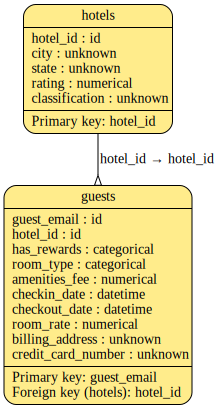

In [ ]:
print('Auto detected data:\n')
metadata.visualize()

The metadata auto-detected the connection between the `hotels` and `guests` table. Each column is associated with an **sdtype**, which describes the type of data.

The auto-detected metadata is not guaranteed to be accurate or complete. For example, notice how some of the columns are shown as `unknown` sdtype. Let's fix these columns to make it more accurate.

## 2.2 Fixing sdtypes

**Hotels table**: Let's start with the hotels.

The `classification` column is meant to be a discrete variable, so we can update it to be categorical.


In [ ]:
metadata.update_column(
    table_name='hotels',
    column_name='classification',
    sdtype='categorical'
)

Notice that the `city` and `state` are also marked as unknown. In some instances, you may want to consider this information as PII, which allows the SDV to anonymize the information.

But in this case, the `city` and `state` are not sensitive attributes, so we can also mark these as categorical.

In [ ]:
metadata.update_column(
    table_name='hotels',
    column_name='city',
    sdtype='categorical'
)

metadata.update_column(
    table_name='hotels',
    column_name='state',
    sdtype='categorical'
)

**Guests table**: Now we can move onto the guests table.

While the `guest_email` column is marked as an ID, we may want to be more specific about what kind of data it is. In this case, the data is an `email` type so we can update it.

In [ ]:
metadata.update_column(
    table_name='guests',
    column_name='guest_email',
    sdtype='email'
)

The `billing_address` and `credit_card_number` columns are PII values. Let's update this in the metadata too.

**Sensitive Columns**: Some columns include sensitive data or personal identifiable information (PII). For these columns, we should use special sdtypes, indicating that we _do not_ want the sensitive values to appear in the synthetic data.

In [ ]:
metadata.update_column(
    table_name='guests',
    column_name='billing_address',
    sdtype='address',
    pii=True
)

metadata.update_column(
    table_name='guests',
    column_name='credit_card_number',
    sdtype='credit_card_number',
    pii=True
)

## 2.3 Validation
Now, the metadata should be accurate. Let's validate that the metadata format makes sense. If successful, the code below should run without any errors.

In [ ]:
metadata.validate()

We can also validate that the metadata accurately matches the data that we provided. Similar to before, the code below should run without any errors.

In [ ]:
metadata.validate_data(data=data)

Finally, we can also visualize the final structure data to verify that the columns and connections are ok.

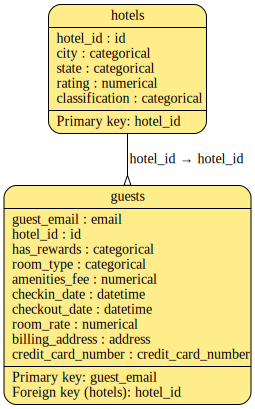

In [ ]:
metadata.visualize()

## 2.4 Saving the Metadata
We strongly recommend saving the metadata as a `JSON` object so we can re-use this description whenever we need to.

In [ ]:
metadata.save_to_json('metadata.json')

# in the future, you can reload the metadata object from the file
metadata = MultiTableMetadata.load_from_json('metadata.json')

# 3. Creating Synthetic Data
With these preparatory steps completed, we can now use the metadata description and data in the SDV. The coe below will train a model and create synthetic data.

In [ ]:
from sdv.multi_table import HMASynthesizer

synthesizer = HMASynthesizer(metadata)
synthesizer.fit(data)
synthetic_data = synthesizer.sample(scale=1)

Preprocess Tables: 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]



Learning relationships:


(1/1) Tables 'hotels' and 'guests' ('hotel_id'): 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Modeling Tables: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]
/usr/local/lib/python3.10/dist-packages/sdv/sampling/hierarchical_sampler.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_rows[foreign_key] = parent_row[parent_key]


The synthetic data contains the same tables, columns and connections as the real data.

In [ ]:
synthetic_data['guests'].head(3)

guest_email  hotel_id  has_rewards room_type  amenities_fee  \
0   moodyeric@example.net  sdv-id-0        False     BASIC           0.59   
1  coryguzman@example.com  sdv-id-0        False     BASIC           2.32   
2  caitlinlee@example.net  sdv-id-0        False     BASIC          11.70   

  checkin_date checkout_date  room_rate  \
0  11 Jan 2020   23 Jan 2020     217.38   
1  19 May 2020   27 Jun 2020     238.86   
2  22 Feb 2020   20 Apr 2020     230.02   

                                     billing_address   credit_card_number  
0                   PSC 4273, Box 0888\nAPO AA 28423     5161033759518983  
1      417 Lawrence Hollow\nEast Ericshire, NM 88906  4133047413145475690  
2  69754 Mcguire Haven Apt. 260\nCrawfordside, RI...        4977328103788

# 4. What's Next?

If you have a single table of data, visit the **[single table documentation](https://docs.sdv.dev/sdv/single-table-data/data-preparation/single-table-metadata-api)** for more details. You may also be interested in our tutorials for **[synthesizing a table](https://colab.research.google.com/drive/1XCwu7NaCYXf3kkhlx4Iei4w2KrXzr1zo)**.

If you have multiple tables, see our tutorial for **[synthesizing multi tables](https://colab.research.google.com/drive/1h_xwzHXrif-xEOC39amYC6xfNPu5hDA1)**.

**Need more help?** [Browse all tutorials](https://docs.sdv.dev/sdv/demos).

---

# About

The [Synthetic Data Vault Project](https://github.com/sdv-dev/SDV) was first created at MIT's Data to AI Lab in 2016. After 4 years of research and traction with enterprise, we created [DataCebo](https://datacebo.com/) in 2020 with the goal of growing the project. Today, DataCebo is the proud developer of SDV, the largest ecosystem for tabular synthetic data generation & evaluation.

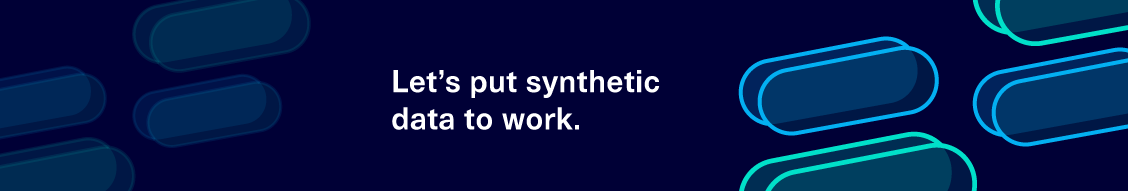